In [309]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
pd.options.mode.chained_assignment = None

In [310]:
who_data = pd.read_csv('https://covid.ourworldindata.org/data/full_data.csv')
jhu_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/'+
                       'COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'+
                       'time_series_19-covid-Confirmed.csv')

In [315]:
country_filter = ['China', 'South Korea', 'Italy', 'France', 'Spain', 'United States']

In [316]:
country_mapper = {
        'Korea, South': 'South Korea',
        'US': 'United States'    
}
jhu_data['Country/Region'] = jhu_data['Country/Region'].map(country_mapper).fillna(jhu_data['Country/Region'])

In [317]:
assert set(country_filter) - set(jhu_data['Country/Region']) == set()

In [318]:
jhu_data_reduced = jhu_data.drop(columns=['Lat', 'Long'])
jhu_data_reduced = jhu_data_reduced.groupby('Country/Region').sum()

In [319]:
jhu_data_reduced = jhu_data_reduced.stack().reset_index()
jhu_data_reduced.columns = ['location', 'date', 'total_cases']
jhu_data_reduced['date'] = pd.to_datetime(jhu_data_reduced['date'])

In [320]:
t0_threshold = 100
who_data_t0 = who_data.query('total_cases >= @t0_threshold')
jhu_data_t0 = jhu_data_reduced.query('total_cases >= @t0_threshold')

In [321]:
t0_date_w = who_data_t0.groupby('location').min()['date']
t0_date_j = jhu_data_t0.groupby('location').min()['date']

In [322]:
who_data_t0.loc[:, 't0_date'] = who_data_t0['location'].map(t0_date_j)
jhu_data_t0.loc[:, 't0_date'] = jhu_data_t0['location'].map(t0_date_w)

In [323]:
who_data_t0.loc[:, 'since_t0'] = pd.to_datetime(who_data_t0['date']) - pd.to_datetime(who_data_t0['t0_date'])
who_data_t0.loc[:, 'since_t0']  = who_data_t0['since_t0'].map(lambda x: x.days)
jhu_data_t0.loc[:, 'since_t0'] = pd.to_datetime(jhu_data_t0['date']) - pd.to_datetime(jhu_data_t0['t0_date'])
jhu_data_t0.loc[:, 'since_t0']  = jhu_data_t0['since_t0'].map(lambda x: x.days)
jhu_data_t0.loc[:, 'since_t0'] = jhu_data_t0.loc[:, 'since_t0'].where(jhu_data_t0['since_t0'] > 0, 0)

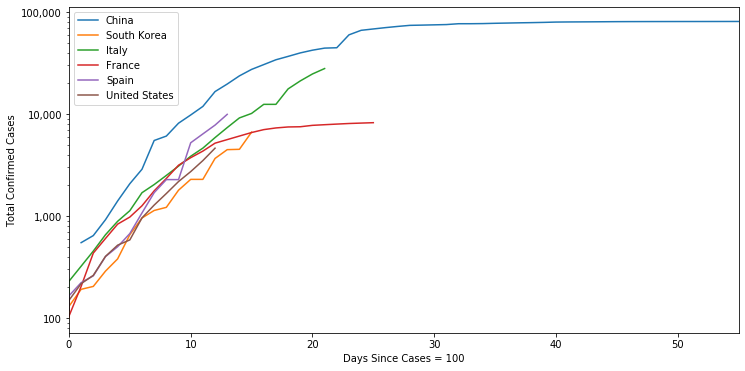

In [326]:
ax = plt.gca()
p=jhu_data_t0[jhu_data_t0['location'].isin(country_filter)].groupby('location').plot(x='since_t0', 
                                                                                     y='total_cases', 
                                                                                     ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(country_filter)
ax.set_xlabel('Days Since Cases = 100')
ax.set_ylabel('Total Confirmed Cases')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

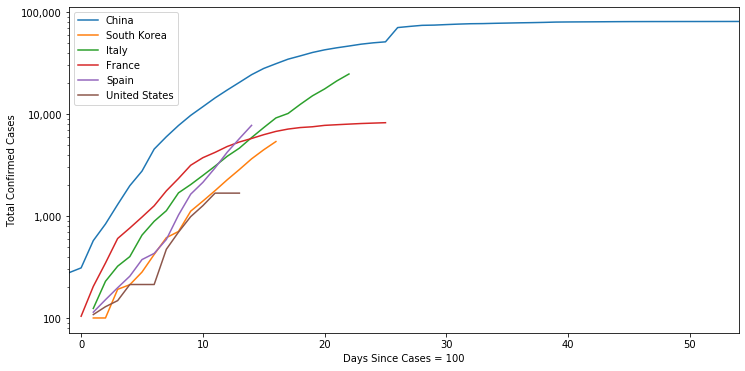

In [327]:
ax = plt.gca()
p=who_data_t0[who_data_t0['location'].isin(country_filter)].groupby('location').plot(x='since_t0', y='total_cases', ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(country_filter)
ax.set_xlabel('Days Since Cases = 100')
ax.set_ylabel('Total Confirmed Cases')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))